In [1]:
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / "_scripts"))

In [35]:
import networkx as nx
from eppy.bunch_subclass import EpBunch
from geomeppy import IDF

from case_edits.ezcase import *
from helpers.ep_helpers import *
from helpers.ep_geom_helpers import *
from helpers.geometry_interfaces import *
from helpers.helpers import *
from plan.helpers import get_plans_from_file
from network.network2 import *
from network.visuals import *
from subsurfaces.logic import get_connecting_surface


In [5]:
inputs_dir = "case_red_d3"
outputs_dir = "tests/test22_svg2plan"

case = initialize_case(outputs_dir)
path_to_input = get_path_to_inputs(inputs_dir)
pairs = get_subsurface_pairs_from_case(path_to_input)

In [6]:
case = create_ezcase(outputs_dir, inputs_dir)
idf = case.idf

out.idf exists
IDF has changed: True


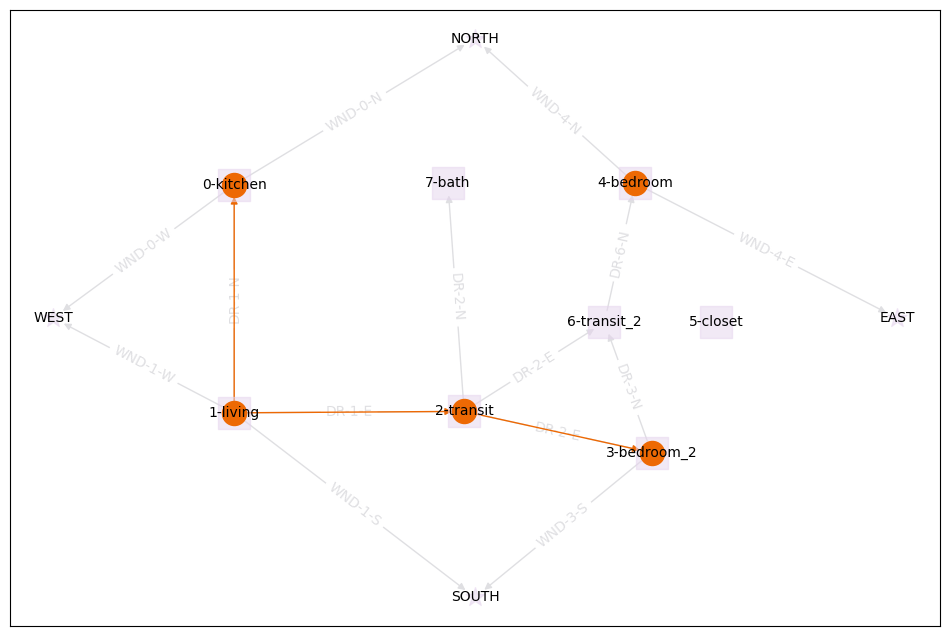

In [37]:
G, positions = create_base_graph(idf, path_to_input)
fig = draw_afn_comparison(idf, G, positions)